# Medida de Regularidade temporal em função das tentativas 

In [1]:
def temporalWindow(X,y,ytrial, windowTrials,clf,returnCubic=True):
    n_classes = len(np.unique(y))

    if not isinstance(clf,SVC):
        clf.fit(X,y)

    times = np.unique(y)
    trials = np.unique(ytrial)

    confusionPerTrial = np.full((n_classes,n_classes,trials.shape[0]),np.nan)
    for i,testTrial in enumerate(trials[:-windowTrials]):
        clfi = clone(clf)
        traintrials = np.array([np.logical_and(t> testTrial, t<testTrial+windowTrials) for t in ytrial])
        clfi.fit(X[traintrials,:],y[traintrials])
        confusionPerTrial[:,:,i] = confusion_matrix(y[ytrial==testTrial], clfi.predict(X[ytrial==testTrial]))

    return confusionPerTrial

In [2]:
def removeTrialsWithMuchActivity(unitTimeTrialCubic, devs = 2,trials=[]):
    trialActivity = unitTimeTrialCubic.sum(axis=1).mean(axis=0)
    base = np.median(trialActivity)
    threshold = base + devs*trialActivity.std()
    print('Removing %d trials' %(trialActivity > threshold).sum())
    
    if len(trials)>0:
        return unitTimeTrialCubic[:,:,trialActivity < threshold], trials[trialActivity < threshold]
    
    return unitTimeTrialCubic[:,:,trialActivity < threshold]

def removeNeuronsThatDoNotFire(unitTimeTrialCubic,threshold = 10):
    trialActivity = unitTimeTrialCubic.mean(axis=2).sum(axis=1)
    print('Removing %d neurons' %(trialActivity < threshold).sum())
    
    return unitTimeTrialCubic[trialActivity > threshold,:,:]

In [11]:
import pandas as pd
from spikeHelper.dataOrganization import loadBestParams, getX,XyTfromEpoch,trialToXyT
from spikeHelper.metrics import performanceFromConfusion
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle


results = pd.DataFrame(columns = ['window','rat','value','trials'])
for windowTrials in [40]:
    ntrials = 30
    for rat in [7]:
        data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
        data, trials = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86,returnTrialN=True)
        print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))

        data = removeTrialsWithMuchActivity(data,devs=2)
        
        parameters = loadBestParams(rat)


        beg = trialToXyT(data[:,:,:ntrials],normalize=False)
        
        clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
        aux = temporalWindow(getX(beg), beg['y'], beg['trial'],windowTrials, clf,returnCubic=True)
        
        #aux = performanceFromConfusion(aux)
        results= pd.concat((results,pd.DataFrame({'window':windowTrials,'rat':rat,'value':[aux],'trials':1},index=[rat])),axis=0) 

results = results.pivot(index='rat',values='value',columns='window')

AttributeError: module 'pandas' has no attribute 'plotting'

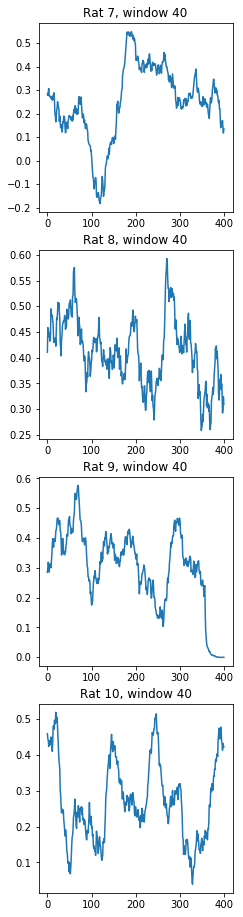

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,4,4*(rat-7)+t+1)
        plt.plot([performanceFromConfusion(results[c][rat][:,:,i:i+30]) for i in range(400)])#results[window][rat].shape[2]-30)])
        plt.title('Rat %s, window %s'%(rat,window))

In [1]:
import pandas

### Testing with trial number corrected


In [3]:
import pandas as pd
from spikeHelper.dataOrganization import loadBestParams, getX,XyTfromEpoch,trialToXyT
from spikeHelper.metrics import performanceFromConfusion
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle


results = pd.DataFrame(columns = ['value','trials'])
for windowTrials in [40]:
    ntrials = -1
    for rat in [7,8,9,10]:
        data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
        data, trials = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86,returnTrialN=True)
        print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
        
        data, trials = removeTrialsWithMuchActivity(data,devs=2,trials=trials)
        
        parameters = loadBestParams(rat)


        beg = trialToXyT(data[:,:,:ntrials],normalize=False)
        trials = trials[:ntrials]
        
        
        clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
        aux = temporalWindow(getX(beg), beg['y'], beg['trial'],windowTrials, clf,returnCubic=True)
        
        #aux = performanceFromConfusion(aux)
        results= pd.concat((results,pd.DataFrame({'value':[aux],'trials':[trials]},index=[rat])),axis=0) 


Calculating for rat 7 using 715 trials and 29 neurons
Removing 39 trials
Calculating for rat 8 using 503 trials and 37 neurons
Removing 20 trials
Calculating for rat 9 using 448 trials and 29 neurons
Removing 22 trials
Calculating for rat 10 using 1110 trials and 65 neurons
Removing 56 trials


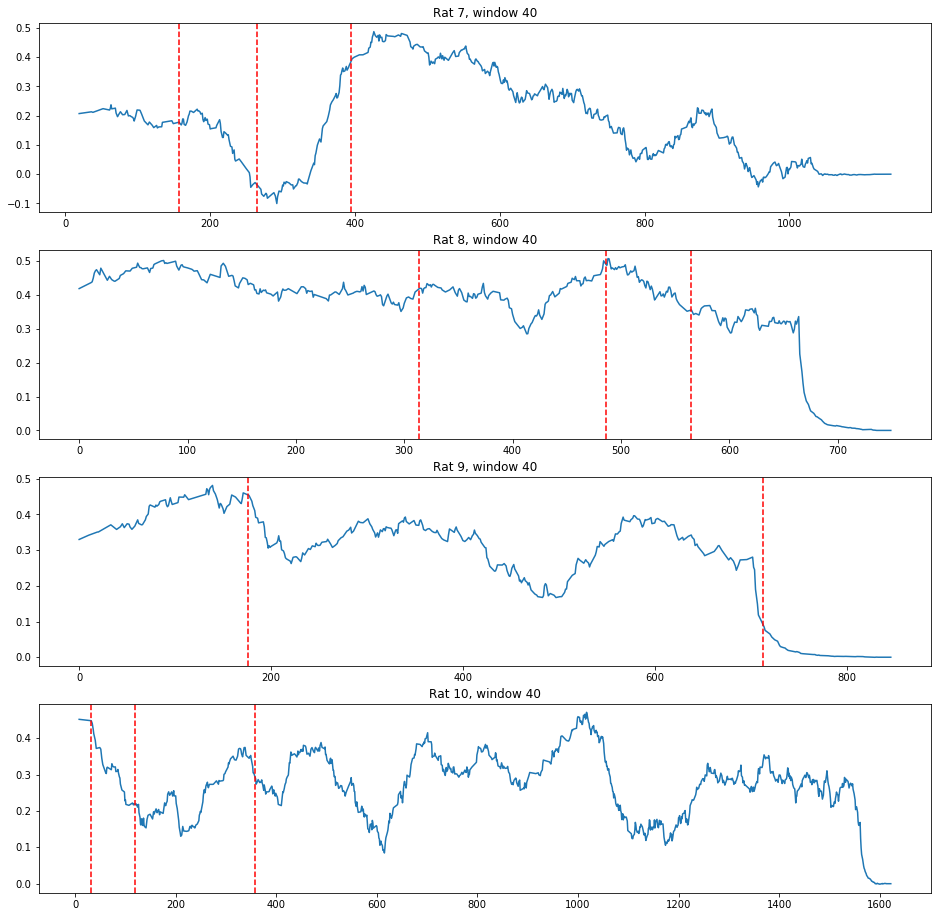

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
cpoints = {7: [157, 265, 394], 8 :[314, 486, 565], 9 : [176, 713], 10 : [32, 119, 357]}

for rat in [7,8,9,10]:
    for t,window in enumerate([40]):
        plt.subplot(4,1,(rat-6))
        
        plt.plot(results['trials'][rat][:results['value'][rat].shape[2]-30],[performanceFromConfusion(results['value'][rat][:,:,i:i+50]) for i in range(results['value'][rat].shape[2]-30)])
        for pt in cpoints[rat]:
            plt.axvline(pt,linestyle='--',color='r')
        plt.title('Rat %s, window %s'%(rat,window))

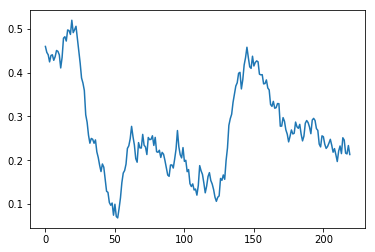

In [24]:
rat = 10
plt.plot([performanceFromConfusion(results[window][rat][:,:,i:i+30]) for i in range(220)])#results[window][rat].shape[2]-30)])


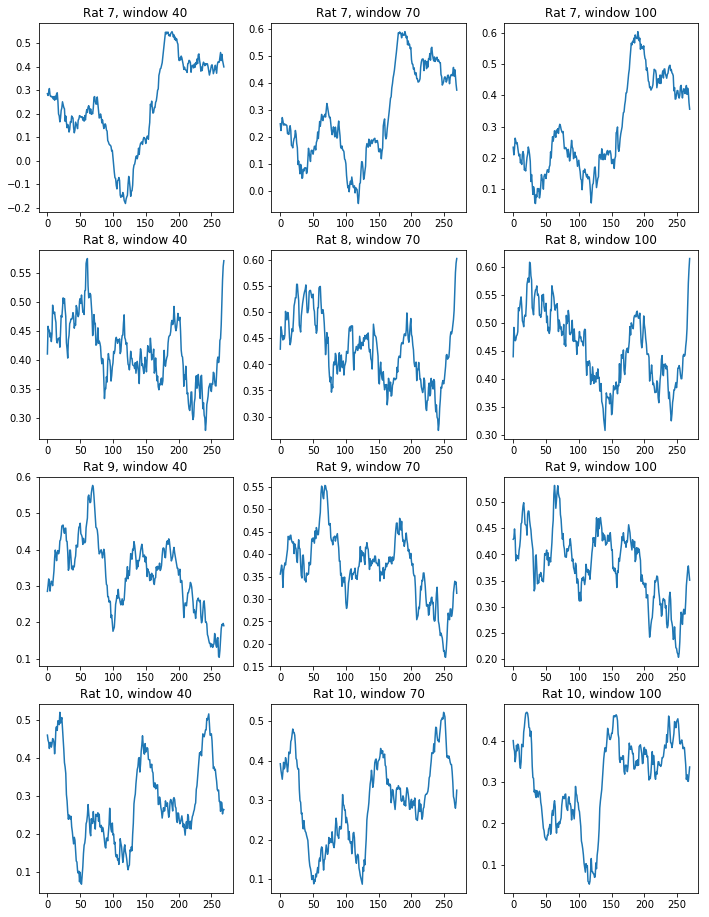

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([40,70,100]):
        plt.subplot(4,4,4*(rat-7)+t+1)
        plt.plot([performanceFromConfusion(results[window][rat][:,:,i:i+30]) for i in range(270)])
        plt.title('Rat %s, window %s'%(rat,window))

/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


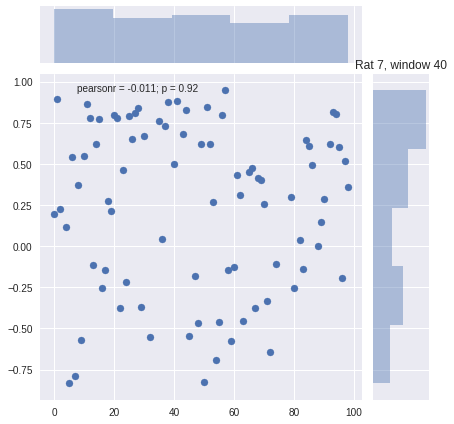

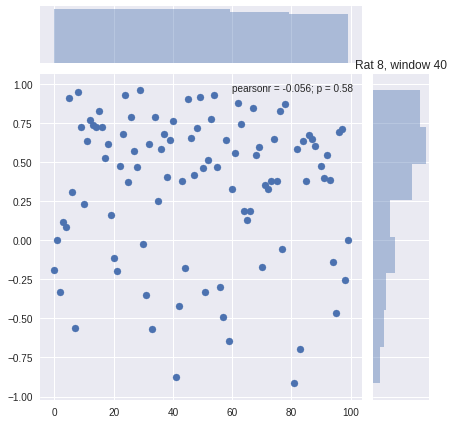

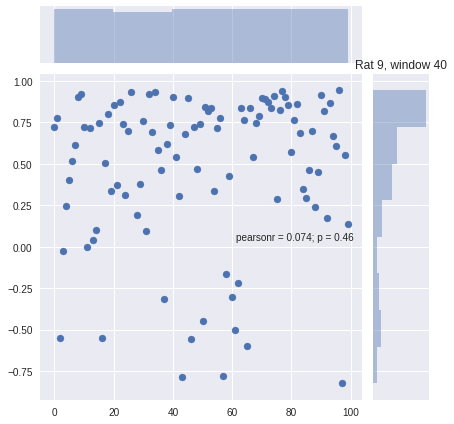

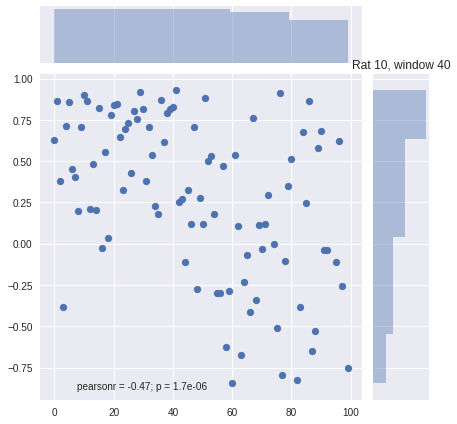

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([40]):
        #plt.subplot(4,4,4*(rat-7)+t+1)
        sns.jointplot(x=np.arange(100),y=np.array([performanceFromConfusion(results[window][rat][:,:,i:i+1]) for i in range(100)]))
        plt.title('Rat %s, window %s'%(rat,window))

# Através de bins normalizados

In [13]:
import pandas as pd
from spikeHelper.dataOrganization import loadBestParams, getX,XyTfromEpoch,trialToXyT
from spikeHelper.metrics import performanceFromConfusion
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import numpy as np


results = pd.DataFrame(columns = ['window','rat','value'])

for windowTrials in [30,40,50,70]:
    ntrials = 100+windowTrials
    for rat in [7,8,9,10]:
        data = pickle.load(open('Data/r'+str(rat)+'_sigma100norm.pickle','rb'))
        data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
        print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))

        parameters = loadBestParams(rat)


        beg = trialToXyT(data[:,:,:ntrials])
        clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
        aux = temporalWindow(getX(beg), beg['y'], beg['trial'],windowTrials, clf,returnCubic=True)
        #aux = performanceFromConfusion(aux)
        results= pd.concat((results,pd.DataFrame({'window':windowTrials,'rat':rat,'value':[aux]},index=[rat])),axis=0) 

results = results.pivot(index='rat',values='value',columns='window')

KeyboardInterrupt: 

In [14]:
data = pickle.load(open('Data/r'+str(rat)+'_sigma100norm.pickle','rb'))

In [18]:
data.applymap(lambda x: x.shape)

,trial 1,trial 2,trial 3,trial 4,trial 5,trial 6,trial 7,trial 8,trial 9,trial 10,...,trial 1183,trial 1184,trial 1185,trial 1186,trial 1187,trial 1188,trial 1189,trial 1190,trial 1191,trial 1192
unit0,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit2,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit3,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit4,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit5,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit6,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit7,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit8,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit9,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"
unit10,"(56,)","(41,)","(36,)","(16,)","(14,)","(20,)","(30,)","(21,)","(15,)","(24,)",...,"(13,)","(14,)","(11,)","(11,)","(11,)","(12,)","(11,)","(23,)","(30,)","(10,)"


/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


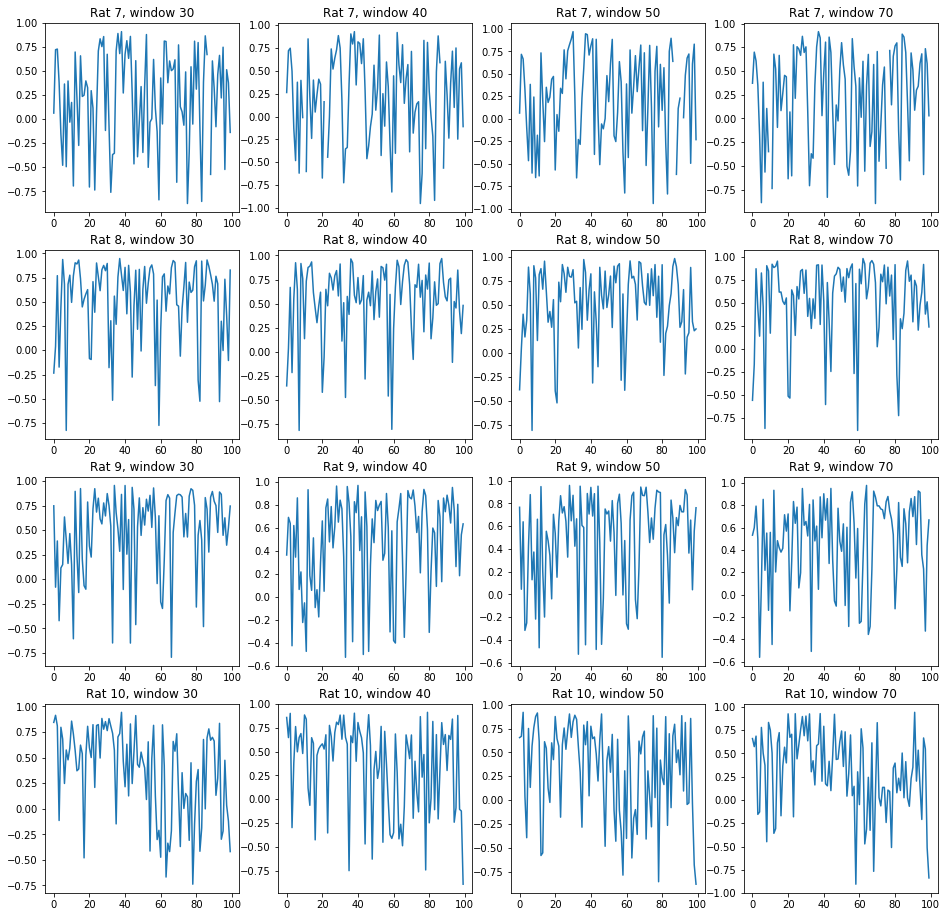

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([30,40,50,70]):
        plt.subplot(4,4,4*(rat-7)+t+1)
        plt.plot([performanceFromConfusion(results[window][rat][:,:,i:i+1]) for i in range(100)])
        plt.title('Rat %s, window %s'%(rat,window))

/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


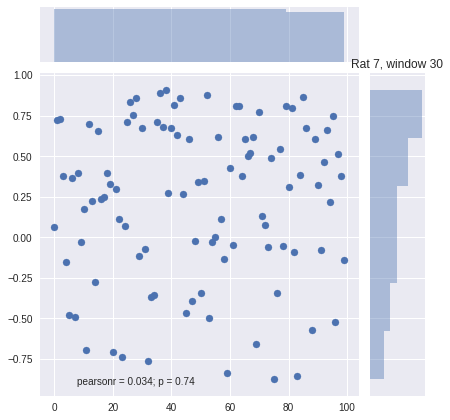

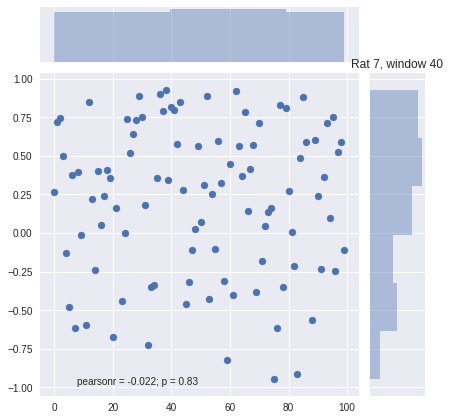

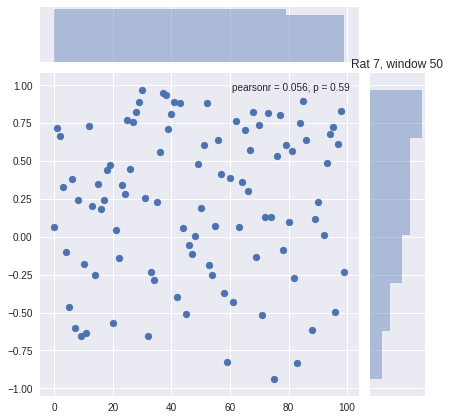

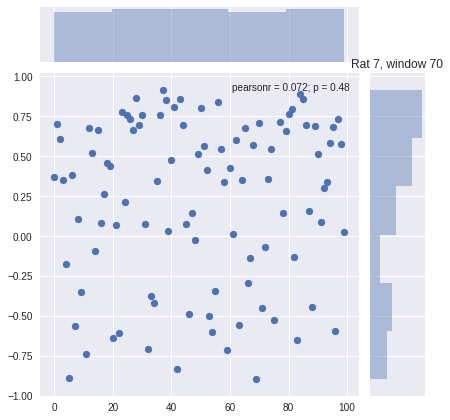

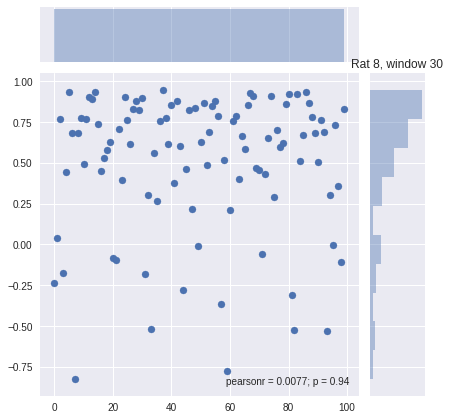

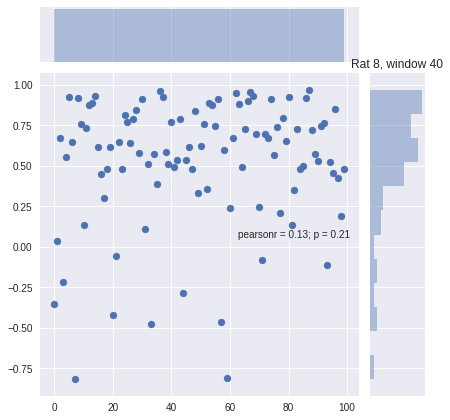

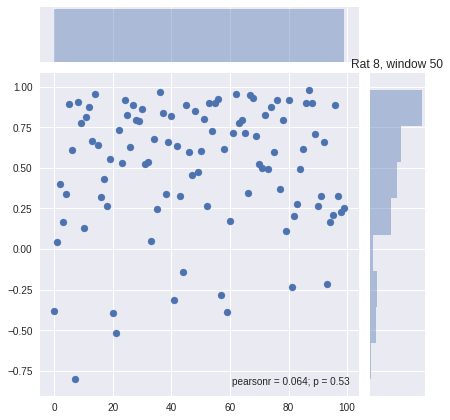

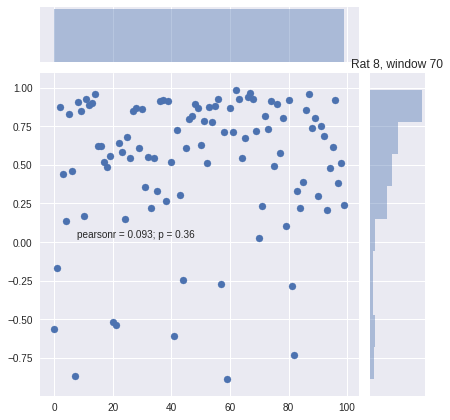

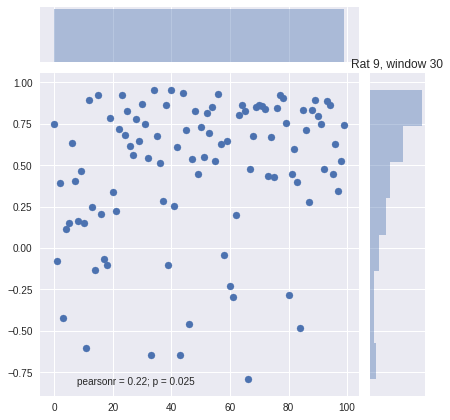

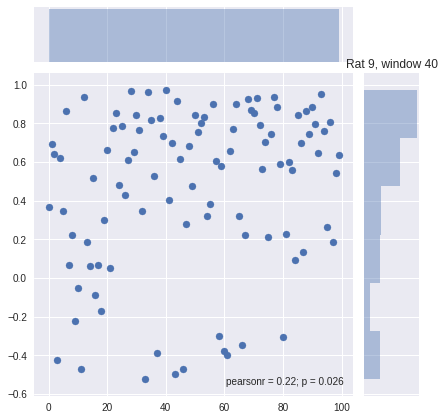

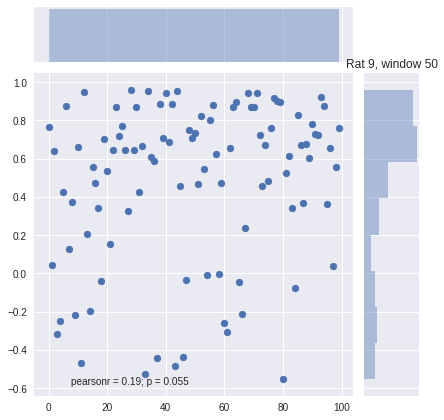

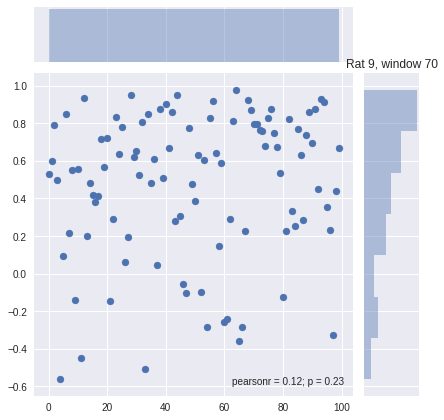

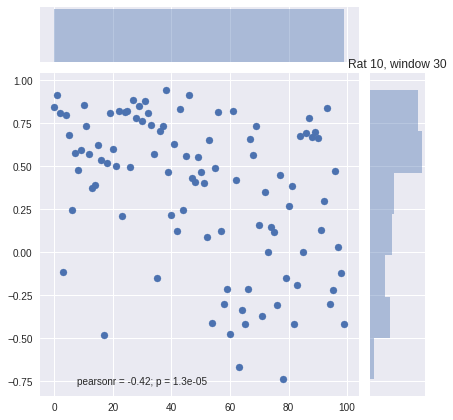

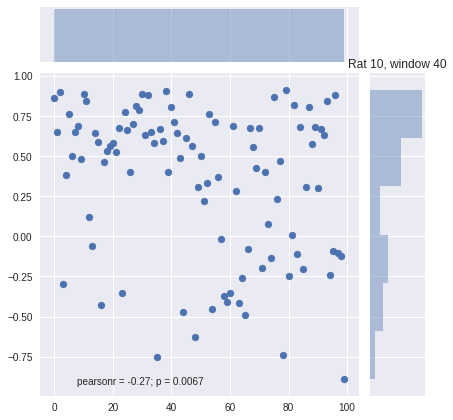

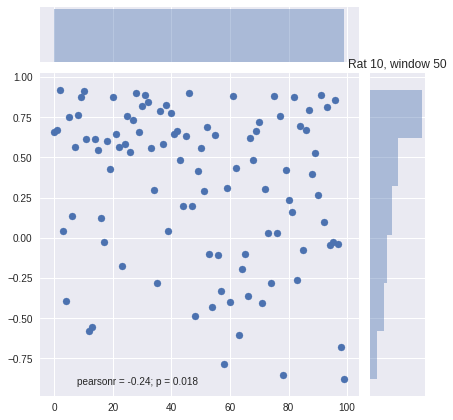

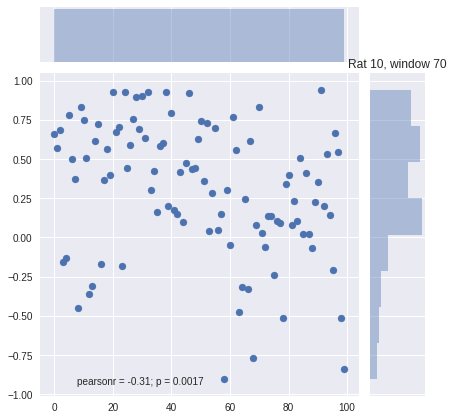

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(16,16))
for rat in [7,8,9,10]:
    for t,window in enumerate([30,40,50,70]):
        #plt.subplot(4,4,4*(rat-7)+t+1)
        sns.jointplot(x=np.arange(100),y=np.array([performanceFromConfusion(results[window][rat][:,:,i:i+1]) for i in range(100)]))
        plt.title('Rat %s, window %s'%(rat,window))